### Results are in Targetted attack_3_7_16.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU: CUDA")
elif torch.backends.mps.is_available():  # Check if MPS (Apple GPU) is available
    device = torch.device("mps")
    print("Using Apple GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple GPU: MPS


In [2]:
# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

In [3]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Remove the first max pooling layer
model.maxpool = nn.Identity()

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


def train(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}"
        )


def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")


# Train the model
train(model, trainloader, criterion, optimizer, num_epochs=20)

# Evaluate the model
evaluate(model, testloader)

# Save the model
torch.save(model.state_dict(), "cifar_resnet18_pretrained.pth")

/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.6527
Epoch [2/20], Loss: 0.2324
Epoch [3/20], Loss: 0.1108
Epoch [4/20], Loss: 0.0531
Epoch [5/20], Loss: 0.0357
Epoch [6/20], Loss: 0.0249
Epoch [7/20], Loss: 0.0233
Epoch [8/20], Loss: 0.0163
Epoch [9/20], Loss: 0.0187
Epoch [10/20], Loss: 0.0209
Epoch [11/20], Loss: 0.0233
Epoch [12/20], Loss: 0.0204
Epoch [13/20], Loss: 0.0180
Epoch [14/20], Loss: 0.0122
Epoch [15/20], Loss: 0.0123
Epoch [16/20], Loss: 0.0044
Epoch [17/20], Loss: 0.0014
Epoch [18/20], Loss: 0.0007
Epoch [19/20], Loss: 0.0004
Epoch [20/20], Loss: 0.0004
Accuracy: 93.36%


In [4]:
# Create patch (random initialization)
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)  # RGB
    return patch

In [5]:
def place_patch(img, patch):
    patch = patch.to(img.device)
    patched_img = img.clone()
    batch_size, _, h, w = patched_img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        patched_img[i, :, x_offset : x_offset + ph, y_offset : y_offset + pw] = patch
    return patched_img

In [6]:
def patch_training_step(
    model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None
):
    model.train()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        patched_images = place_patch(images, patch)  # Apply patch to images
        outputs = model(patched_images)

        if target_class is not None:
            labels = torch.full(
                (images.size(0),), target_class, dtype=torch.long, device=device
            )
            loss = criterion(outputs, labels)
        else:
            loss = -criterion(outputs, labels)  # reverse the loss

        # loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            patch.clamp_(-1, 1)  # Ensure the patch values remain within a valid range

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [7]:
def train_adversarial_patch(
    model, patch, dataloader=None, target_class=None, num_epochs=20, lr=0.0001
):
    if dataloader is None:
        dataloader = trainloader

    patch_optimizer = optim.Adam(
        [patch], lr=lr
    )  # Use Adam optimizer for learning rate adjustment

    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(
            model, patch, target_class, dataloader, patch_optimizer, criterion
        )
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

In [8]:
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (
                    (predicted != labels).sum().item()
                )  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total

    if target_class is not None:
        print(f"Targeted Attack Success Rate (Class {target_class}): {accuracy:.2f}%")
    else:
        print(f"Untargeted Attack Success Rate: {accuracy:.2f}%")

In [17]:
target_classes = [7, 8, 9]
class_names = {7: "horse", 8: "ship", 9: "truck"}
# target_classes = [8, 9]
# class_names = {8: "ship", 9: "truck"}

In [12]:
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )

    patch_size = (5, 5)
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 12.8866
Epoch 2/20, Loss: 12.8420
Epoch 3/20, Loss: 12.7905
Epoch 4/20, Loss: 12.7586
Epoch 5/20, Loss: 12.7375
Epoch 6/20, Loss: 12.6941
Epoch 7/20, Loss: 12.6560
Epoch 8/20, Loss: 12.6338
Epoch 9/20, Loss: 12.6049
Epoch 10/20, Loss: 12.5758
Epoch 11/20, Loss: 12.5418
Epoch 12/20, Loss: 12.5226
Epoch 13/20, Loss: 12.4825
Epoch 14/20, Loss: 12.4827
Epoch 15/20, Loss: 12.4482
Epoch 16/20, Loss: 12.4195
Epoch 17/20, Loss: 12.4072
Epoch 18/20, Loss: 12.3874
Epoch 19/20, Loss: 12.3723
Epoch 20/20, Loss: 12.3596
Saved patch to adversarial_patch_ship.pth
--- Evaluating Patch for Target Class: ship (8) ---
Targeted Attack Success Rate (Class 8): 9.74%

--- Training Patch for Target Class: truck (9) ---
Epoch 1/20, Loss: 13.0365
Epoch 2/20, Loss: 13.0124
Epoch 3/20, Loss: 12.9931
Epoch 4/20, Loss: 12.9451
Epoch 5/20, Loss: 12.9176
Epoch 6/20, Loss: 12.8749
Epoch 7/20, Loss: 12.8362
Epoch 8/20, Loss: 12.8117
Epoch 9/20, Loss: 

##### Horse: (5 x 5)
--- Training Patch for Target Class: horse (7) ---

Epoch 1/20, Loss: 13.3451

Epoch 2/20, Loss: 13.3152

Epoch 3/20, Loss: 13.2668

Epoch 4/20, Loss: 13.2387

Epoch 5/20, Loss: 13.1903

Epoch 6/20, Loss: 13.1648

Epoch 7/20, Loss: 13.1378

Epoch 8/20, Loss: 13.0996

Epoch 9/20, Loss: 13.0725

Epoch 10/20, Loss: 13.0444

Epoch 11/20, Loss: 13.0089

Epoch 12/20, Loss: 12.9892

Epoch 13/20, Loss: 12.9522

Epoch 14/20, Loss: 12.9428

Epoch 15/20, Loss: 12.9147

Epoch 16/20, Loss: 12.8914

Epoch 17/20, Loss: 12.8812

Epoch 18/20, Loss: 12.8667

Epoch 19/20, Loss: 12.8404

Epoch 20/20, Loss: 12.8337

Saved patch to adversarial_patch_horse.pth

--- Evaluating Patch for Target Class: horse (7) ---

Targeted Attack Success Rate (Class 7): 9.96%

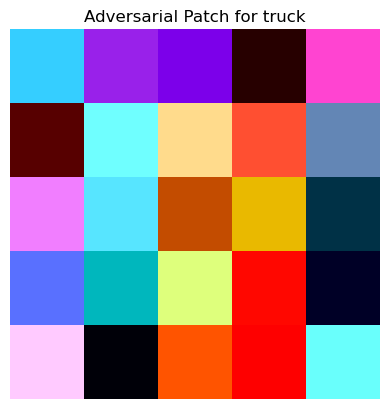

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_patch(patch, title="Adversarial Patch"):
    # Detach and move to CPU
    patch = patch.detach().cpu()
    # Convert to numpy and transpose to (H, W, C)
    patch_np = patch.permute(1, 2, 0).numpy()
    # Unnormalize if necessary
    patch_np = (patch_np * 0.5) + 0.5  # Assuming normalization was (-1, 1)
    patch_np = np.clip(patch_np, 0, 1)

    plt.imshow(patch_np)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Example usage after training each patch
visualize_patch(patch, title=f"Adversarial Patch for {class_names[target_class]}")

In [ ]:
# Define the class names for CIFAR-10
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [23]:
def denormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Denormalize a tensor image.

    Args:
        tensor (torch.Tensor): Normalized image tensor.
        mean (tuple): Mean used for normalization.
        std (tuple): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [24]:
def visualize_misclassified_patched_images(
    model, patch, dataloader, target_class=None, num_images=5
):
    """
    Visualize misclassified images after applying the adversarial patch.

    Args:
        model (nn.Module): Trained CIFAR-10 classifier.
        patch (torch.Tensor): Trained adversarial patch.
        dataloader (DataLoader): DataLoader for evaluation data.
        target_class (int, optional): Target class for targeted attacks. Defaults to None for untargeted attacks.
        num_images (int, optional): Number of misclassified images to visualize. Defaults to 5.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            if target_class is not None:
                # Only include images not originally of target_class but predicted as target_class
                mask = (predicted == target_class) & (labels != target_class)
            else:
                # Untargeted Attack: Any prediction that doesn't match the true label
                mask = predicted != labels

            for i in range(images.size(0)):
                if mask[i]:
                    misclassified.append(
                        (
                            images[i].cpu(),
                            patched_images[i].cpu(),
                            labels[i].cpu(),
                            predicted[i].cpu(),
                        )
                    )
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    if not misclassified:
        print("No misclassified images found with the current patch.")
        return

    # Plotting
    for idx, (orig, patched, true_label, pred_label) in enumerate(misclassified):
        orig = denormalize(orig).permute(1, 2, 0).numpy()
        patched = denormalize(patched).permute(1, 2, 0).numpy()

        orig = np.clip(orig, 0, 1)
        patched = np.clip(patched, 0, 1)

        plt.figure(figsize=(4, 2))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(orig)
        plt.title(f"Original\nTrue: {class_names[true_label.item()]}")
        plt.axis("off")

        # Patched Image
        plt.subplot(1, 2, 2)
        plt.imshow(patched)
        plt.title(f"Patched\nPredicted: {class_names[pred_label.item()]}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_99320/1081996510.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)

Targeted Attack Success Rate (Class 7): 9.25%


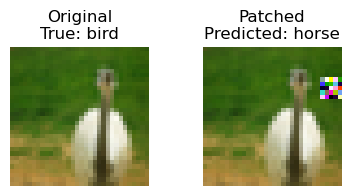

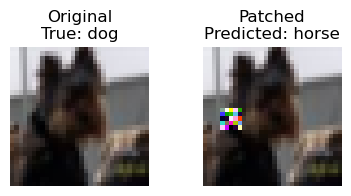

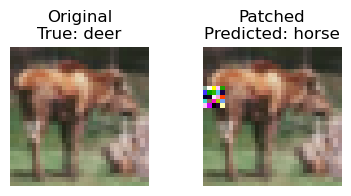

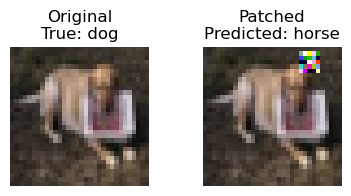

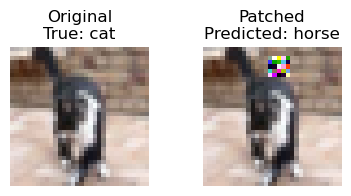

Targeted Attack Success Rate (Class 8): 9.85%


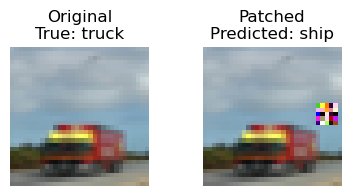

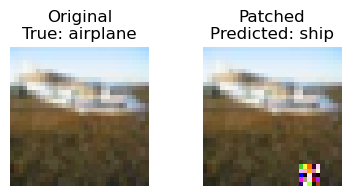

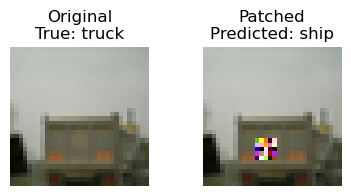

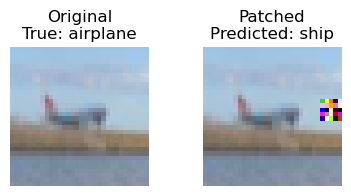

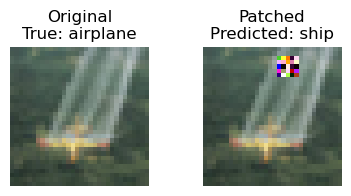

Targeted Attack Success Rate (Class 9): 9.98%


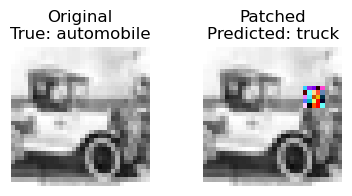

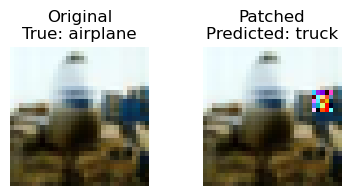

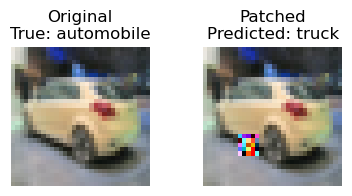

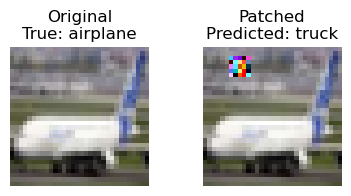

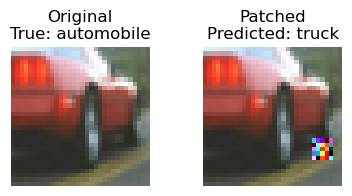

In [25]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )